# Black-Scholes Calculations & Greeks

The model takes in 6 key parameters:

- *\( S \)*: Current underlying price
- *\( K \)*: Strike price  
- *\( T \)*: Time to maturity (annualised)  
- *\( r \)*: Risk-free interest rate  
- *\( $\sigma$\)*: Volatility of the underlying stock  
- *\( q \)*: Dividend yield 

The Black-Scholes Call Option Formula is:
\begin{equation}
C = S e^{-qT} N(d_1) - K e^{-rT} N(d_2)
\end{equation}

The Black-Scholes Put Option Formula is:
\begin{equation}
P = K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1)
\end{equation}

where: 
\begin{equation}
d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2)T}{\sigma \sqrt{T}}
\end{equation}

\begin{equation}
d_2 = d_1 - \sigma \sqrt{T}
\end{equation}

In [244]:
import sys
!{sys.executable} -m pip install jax
!{sys.executable} -m pip install blackscholes
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install matplotlib

In [282]:
import jax.numpy as jnp
from jax import grad
from jax.scipy.stats import norm as jnorm
import blackscholes as bs
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Calculating the Black-Scholes Theoretical Price

In this section, we implement the equations for Black-Scholes into Python:

In [42]:
def black_scholes_call(S, K, T, r, sig, q):
    d1 = (jnp.log(S/K)+(r-q+0.5*(sig**2))*T)/(sig*jnp.sqrt(T))
    d2 = d1-sig*jnp.sqrt(T)
    C = S*jnp.exp(-q*T)*jnorm.cdf(d1)-K*jnp.exp(-r*T)*jnorm.cdf(d2)
    return C

def black_scholes_put(S, K, T, r, sig, q):
    d1 = (jnp.log(S/K)+(r-q+0.5*(sig**2))*T)/(sig*jnp.sqrt(T))
    d2 = d1-sig*jnp.sqrt(T)
    P = K*jnp.exp(-r*T)*jnorm.cdf(-d2)-S*jnp.exp(-q*T)*jnorm.cdf(-d1)
    return P


## Testing the Equations Against Reference Values

In [58]:
S=100
K =110
T=0.8
r=0.05
sigma = 0.2
q=0
call_price = black_scholes_call(S, K, T, r, sigma, q)
reference_call = bs.BlackScholesCall(S, K, T, r, sigma, q)
reference_price = reference_call.price()

print(f"The Equation Predicted Price: {call_price}")
print(f"The Package Predicted Price: {reference_price}")

The Equation Predicted Price: 4.832782745361328
The Package Predicted Price: 4.832781409220807


In [80]:
S=100.0
K =110.0
T=0.8
r=0.05
sigma = 0.2
q=0.0
put_price = black_scholes_put(S, K, T, r, sigma, q)
reference_put = bs.BlackScholesPut(S, K, T, r, sigma, q)
reference_price = reference_put.price()

print(f"The Equation Predicted Price: {put_price}")
print(f"The Package Predicted Price: {reference_price}")

The Equation Predicted Price: 10.519615173339844
The Package Predicted Price: 10.519619715976347


# 📈 Option Sensitivities: Greeks

---

#### 🔺 Delta \( $\Delta$\)

The rate of change of the option price with respect to the price of the underlying asset:

$$
\Delta = \frac{\partial C}{\partial S}
$$

---

#### 🔼 Gamma \( $\Gamma$ \)

The rate of change of Delta with respect to the price of the underlying asset. It is the second derivative of the option price with respect to the asset price:

$$
\Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{\partial \Delta}{\partial S}
$$

---

#### ⏳ Theta \( $\Theta$ \)

The rate of change of the option price with respect to the passage of time (i.e., time decay):

$$
\Theta = \frac{\partial C}{\partial T}
$$

---

#### 💰 Rho \( $\rho$ \)

The rate of change of the option price with respect to the risk-free interest rate:

$$
\rho = \frac{\partial C}{\partial r}
$$

---

#### 🌪️ Vega \( $\nu$ \)

The rate of change of the option price with respect to the volatility of the underlying asset:

$$
\nu = \frac{\partial C}{\partial \sigma}
$$

In [98]:
delta = grad(black_scholes_call, argnums=0)
gamma = grad(delta, argnums=0)
vega = grad(black_scholes_call, argnums=4)
theta = grad(black_scholes_call, argnums=2)
rho = grad(black_scholes_call, argnums=3)

calculated_delta = delta(S,K,T,r,sigma,q)
calculated_gamma = gamma(S,K,T,r,sigma,q)
calculated_theta = -theta(S,K,T,r,sigma,q)
calculated_rho = rho(S,K,T,r,sigma,q)
calculated_vega = vega(S,K,T,r,sigma,q)

print("---------------------------")
print(f"Our Estimated Vega: {calculated_vega}")
print(f"Model Estimated Vega {reference_call.vega()}")
print("---------------------------")
print(f"Our Estimated Delta: {calculated_delta}")
print(f"Model Estimated Delta {reference_call.delta()}")
print("---------------------------")
print(f"Our Estimated Gamma: {calculated_gamma}")
print(f"Model Estimated Gamma {reference_call.gamma()}")
print("---------------------------")
print(f"Our Estimated Rho: {calculated_rho}")
print(f"Model Estimated Rho {reference_call.rho()}")
print("---------------------------")
print(f"Our Estimated Theta: {calculated_theta}")
print(f"Model Estimated Theta {reference_call.theta()}")
print("---------------------------")

---------------------------
Our Estimated Vega: 34.831241607666016
Model Estimated Vega 34.83124111278067
---------------------------
Our Estimated Delta: 0.41303279995918274
Model Estimated Delta 0.4130327029103781
---------------------------
Our Estimated Gamma: 0.021769531071186066
Model Estimated Gamma 0.021769525695487915
---------------------------
Our Estimated Rho: 29.176401138305664
Model Estimated Rho 29.1763911054536
---------------------------
Our Estimated Theta: -6.177430152893066
Model Estimated Theta -6.177429583188434
---------------------------


In [103]:
delta = grad(black_scholes_put, argnums=0)
gamma = grad(delta, argnums=0)
vega = grad(black_scholes_put, argnums=4)
theta = grad(black_scholes_put, argnums=2)
rho = grad(black_scholes_put, argnums=3)

calculated_delta = delta(S,K,T,r,sigma,q)
calculated_gamma = gamma(S,K,T,r,sigma,q)
calculated_theta = -theta(S,K,T,r,sigma,q)
calculated_rho = rho(S,K,T,r,sigma,q)
calculated_vega = vega(S,K,T,r,sigma,q)

print("---------------------------")
print(f"Our Estimated Vega: {calculated_vega}")
print(f"Model Estimated Vega {reference_put.vega()}")
print("---------------------------")
print(f"Our Estimated Delta: {calculated_delta}")
print(f"Model Estimated Delta {reference_put.delta()}")
print("---------------------------")
print(f"Our Estimated Gamma: {calculated_gamma}")
print(f"Model Estimated Gamma {reference_put.gamma()}")
print("---------------------------")
print(f"Our Estimated Rho: {calculated_rho}")
print(f"Model Estimated Rho {reference_put.rho()}")
print("---------------------------")
print(f"Our Estimated Theta: {calculated_theta}")
print(f"Model Estimated Theta {reference_put.theta()}")
print("---------------------------")

---------------------------
Our Estimated Vega: 34.831241607666016
Model Estimated Vega 34.83124111278067
---------------------------
Our Estimated Delta: -0.5869672298431396
Model Estimated Delta -0.5869672970896219
---------------------------
Our Estimated Gamma: 0.021769531071186066
Model Estimated Gamma 0.021769525695487915
---------------------------
Our Estimated Rho: -55.37307357788086
Model Estimated Rho -55.373079539950844
---------------------------
Our Estimated Theta: -0.8930881023406982
Model Estimated Theta -0.8930876678506556
---------------------------


## Implied Volatility Estimation Using Newton-Raphson Method

To compute the **implied volatility** \( \sigma_{\text{imp}} \) of an option, we must solve the equation:

$$
BS_{\text{call}}(S, K, T, r, \sigma_{\text{imp}}, q) = P_{\text{market}}
$$

However, the Black-Scholes formula cannot be algebraically inverted to isolate \( \sigma_{\text{imp}} \). Therefore, we apply the **Newton-Raphson method**, a numerical root-finding algorithm, to approximate the value of implied volatility.

---

### Newton-Raphson Formula

We define a function:

$$
f(\sigma) = BS_{\text{call}}(S, K, T, r, \sigma, q) - P_{\text{market}}
$$

We aim to find the root of \( f(\sigma) \), that is, where the model price equals the market price. The Newton-Raphson update rule is:

$$
\sigma_{n+1} = \sigma_n - \frac{f(\sigma_n)}{f'(\sigma_n)}
$$

Where:
- \( f(\sigma_n) \) is the difference between the model and market price at iteration \( n \),
- \( f'(\sigma_n) \) is the derivative of the price function with respect to \( \sigma \), known as **Vega** in options theory.

---

### Iterative Procedure

1. **Start** with an initial guess \( \sigma_0 \).
2. **Evaluate** the loss function:
   $$
   \text{Loss} = BS_{\text{call}}(S, K, T, r, \sigma_n, q) - P_{\text{market}}
   $$
3. **Compute** the gradient \( f'(\sigma_n) \) (e.g. via autograd).
4. **Update** the volatility estimate using:
   $$
   \sigma_{n+1} = \sigma_n - \frac{\text{Loss}}{\text{Gradient}}
   $$
5. **Repeat** until \( |\text{Loss}| < \epsilon \) or a maximum number of iterations is reached.

---

### Convergence Safeguards

To ensure stable convergence:
- Stop if the gradient is too small (e.g., \( < 10^{-8} \)) to avoid division by zero.
- Return `"nan"` if \( \sigma_n \leq 0 \) or becomes `NaN`.

---

This approach is effective in practice and commonly used in quantitative finance for its speed and reliability, especially when paired with automatic differentiation for the gradient calculation.


In [132]:
def loss(S,K,T,r,sigma_predicted, price, q=0.0):
    predicted_price = black_scholes_call(S,K,T, r,sigma_predicted, q)
    market_price = price
    return predicted_price - market_price

loss_gradient = grad(loss, argnums=4)

In [360]:
def solve_for_impliedvol(S, K, T, r, price, sigma_guess=0.2, q=0.0, N_iter=50, epsilon=0.001):
    sigma = sigma_guess

    for i in range(N_iter):
        loss_val = loss(S, K, T, r, sigma, price, q)

        # Stop if converged
        if jnp.abs(loss_val) < epsilon:
            return float(sigma)

        loss_grad_val = loss_gradient(S, K, T, r, sigma, price, q)

        # Safeguard: avoid division by very small gradient
        if jnp.abs(loss_grad_val) < 1e-8:
            break

        sigma = sigma - loss_val / loss_grad_val

        # Clamp to minimum value (avoid negatives or zero)
        if sigma <= 0 or jnp.isnan(sigma):
            return "nan"

    return "nan" # If no convergence

# Test Case

In [363]:
S = 100
K = 100
T = 0.5
r = 0.01
q = 0.0
true_sigma = 0.25

price = float(black_scholes_call(S, K, T, r, true_sigma, q))
implied_vol = solve_for_impliedvol(S, K, T, r, price)

print("True vol:", true_sigma)
print("Recovered IV:", implied_vol)

True vol: 0.25
Recovered IV: 0.24997222423553467


## Option Chain Data Retrieval and Implied Volatility Calculation

In this analysis, we utilize options market data sourced from **MarketData.com**. Access to this data is limited for users without an API key; specifically, only data for **Apple Inc. (AAPL)** is available.

We extract the full option chain for AAPL, which includes the following key variables for each option contract:

- Option price \( P \)
- Underlying asset price \( S \)
- Expiration time \( T \) (in years)
- Strike price \( K \)
- Risk-free interest rate \( r \)
- Dividend yield \( q \)

Using this data, we construct a structured DataFrame where each row corresponds to an individual option contract. For each call option, we then solve numerically for its **implied volatility** \( \sigma_{\text{imp}} \) by inverting the Black-Scholes pricing formula:

\begin{equation}
P_{\text{market}} = BS_{\text{call}}(S, K, T, r, \sigma_{\text{imp}}, q)
\end{equation}

Only valid solutions (i.e., real-valued implied volatilities) are retained for further analysis. We also compute:

- **Moneyness**: S/K
- **Time to Expiry**: T 

These variables are then used to create a


In [365]:
def time_to_maturity(expiration_str):
    """
    Calculate the time to maturity in years from today to expiration date.
    
    Args:
    expiration_str (str): Expiration date in 'YYYY-MM-DD' format.
    
    Returns:
    float: Time to maturity in years.
    """
    expiration_date = datetime.strptime(expiration_str, "%Y-%m-%d").date()
    today = datetime.today().date()
    delta_days = (expiration_date - today).days
    return max(delta_days / 365.0, 0)  # Avoid negative values
T= time_to_maturity(expiration)

In [380]:
def get_option_chain(ticker, years):
    """
    Fetches option chain data for a given ticker, returning only entries with time to maturity ≤ years.

    Parameters:
    ticker (str): Stock ticker symbol (e.g., 'AAPL')
    years (float): Maximum maturity in years (e.g., 0.25 for 3 months)

    Returns:
    pd.DataFrame: Filtered DataFrame with full option metadata
    """
    # Date range for expirations (50-year max, but we'll filter later)
    today = datetime.today().date()
    future = today + timedelta(days=50 * 365)
    from_date = today.strftime("%Y-%m-%d")
    to_date = future.strftime("%Y-%m-%d")

    # API request to get all expirations
    expirations_url = f"https://api.marketdata.app/v1/options/expirations/{ticker}?from={from_date}&to={to_date}"
    exp_response = requests.get(expirations_url)
    exp_data = exp_response.json()

    combined_df = pd.DataFrame()

    for expiry_date in exp_data['expirations']:
        # Fetch the option chain for each expiration date
        chain_url = f"https://api.marketdata.app/v1/options/chain/{ticker}/?expiration={expiry_date}"
        response = requests.get(chain_url)
        data = response.json()

        # Ensure essential data exists
        if 'strike' not in data or 'bid' not in data or 'ask' not in data:
            continue

        # Compute option prices (midpoint of bid and ask)
        option_price = [(b + a) / 2 for b, a in zip(data['bid'], data['ask'])]

        # Constants
        r = 0.045
        q = 0.0
        T = time_to_maturity(expiry_date)

        # Build DataFrame for this expiration
        df = pd.DataFrame({
            'Symbol': [ticker] * len(data['strike']),
            'OptionPrice': option_price,
            'UnderlyingPrice': data['underlyingPrice'],
            'Expiration': [expiry_date] * len(data['strike']),
            'Strike': data['strike'],
            'OptionType': data['side'],
            'risk_free_rate': [r] * len(data['strike']),
            'dividend_yield': [q] * len(data['strike']),
            'T': [T] * len(data['strike'])
        })

        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Filter: Keep only rows where T <= years
    filtered_df = combined_df[combined_df["T"] <= years].reset_index(drop=True)

    return filtered_df

In [406]:
# Define ticker and time horizon
ticker = "AAPL"
years = 0.5

# Fetch option chain data
options_df = get_option_chain(ticker, years)
print(options_df)

# Initialize storage for implied volatilities, moneyness, and time to expiry
implied_vols = []
moneyness_list = []
time_to_expiry = []

# Iterate over the option chain DataFrame
for index, row in options_df.iterrows():
    print(f"Completed: {index + 1}/{len(options_df)}")

    # Process only call options
    if row['OptionType'] == 'call':
        strike_price = row["Strike"]
        time_to_maturity = row["T"]
        market_price = row["OptionPrice"]
        spot_price = row["UnderlyingPrice"]
        risk_free_rate = row['risk_free_rate']

        # Calculate implied volatility
        iv = solve_for_impliedvol(spot_price, strike_price, time_to_maturity, risk_free_rate, market_price)
        print(iv)

        # Append values if IV is valid
        if iv != "nan":
            print("yes")
            implied_vols.append(float(iv))
            moneyness_list.append(spot_price / strike_price)
            time_to_expiry.append(time_to_maturity)


     Symbol  OptionPrice  UnderlyingPrice  Expiration  Strike OptionType  \
0      AAPL       93.075           193.16  2025-04-25   100.0       call   
1      AAPL       83.400           193.16  2025-04-25   110.0       call   
2      AAPL       73.075           193.16  2025-04-25   120.0       call   
3      AAPL       68.400           193.16  2025-04-25   125.0       call   
4      AAPL       67.275           193.16  2025-04-25   126.0       call   
...     ...          ...              ...         ...     ...        ...   
1261   AAPL      151.975           193.16  2025-10-17   345.0        put   
1262   AAPL      157.000           193.16  2025-10-17   350.0        put   
1263   AAPL      161.875           193.16  2025-10-17   355.0        put   
1264   AAPL      166.775           193.16  2025-10-17   360.0        put   
1265   AAPL      176.900           193.16  2025-10-17   370.0        put   

      risk_free_rate  dividend_yield         T  
0              0.045             0.0  

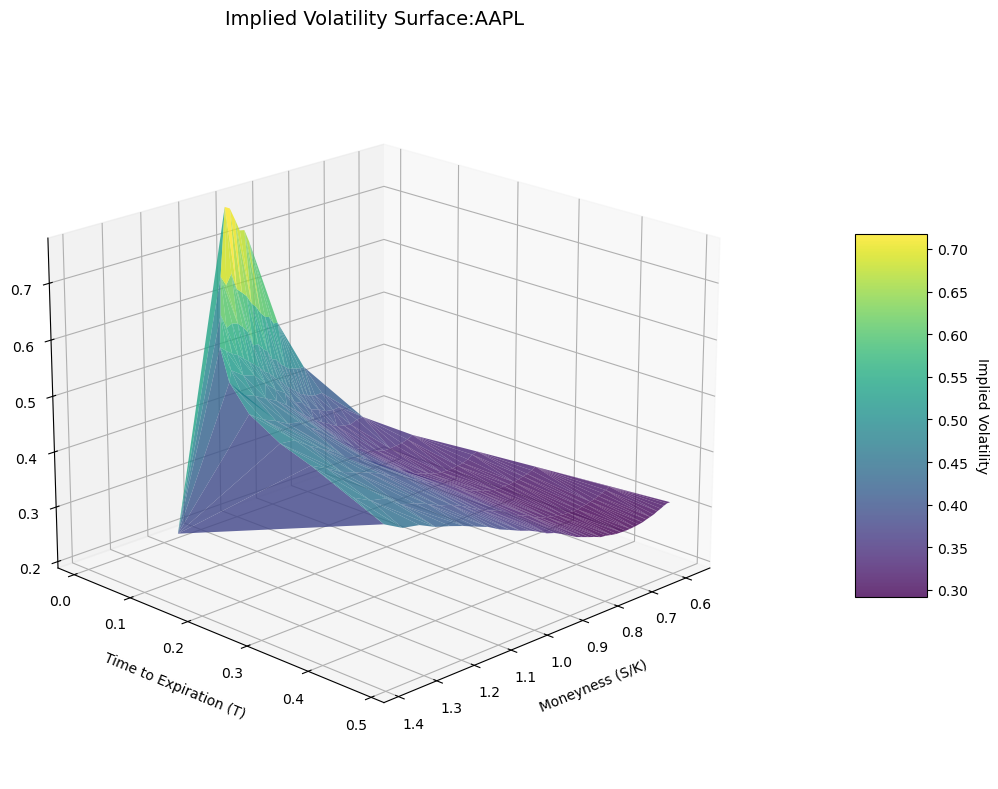

In [393]:

fig = plt.figure(figsize=(12,8), dpi=100)
ax=fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(moneyness, dtes, ivs, cmap='viridis', linewidth=0.1, antialiased=True, alpha =0.8)
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect =5, pad=0.1)
cbar.set_label('Implied Volatility', rotation = 270, labelpad=15)

ax.set_xlabel('Moneyness (S/K)', labelpad=10)
ax.set_ylabel('Time to Expiration (T)', labelpad=10)
ax.set_zlabel('Implied Volatility', labelpad=10)
plt.title(f"Implied Volatility Surface:{ticker}", pad=20, size=14)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()